```markdown
MACHINE LEARNING EMG PROJECT
```
``
Project Workflow
``
`
Data pre-processing
`
Feature Design
`
Develelopment of Models
`
Training
`

In [2]:
import os
import importlib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

from tabulate import tabulate

#  Data Cleaning

In [3]:
#readin in the data
df = pd.read_csv('Project_Data_EE4C12_S&S_EMG.csv')
classes=np.array([
    'unmarked data',
    'hand at rest',
    'clenched fist',
    'wrist flexion',
    'wrist extension',
    'radial deviations',
    'ulnar deviations',
    'extended palm'
])

print(df.head())
print(df.shape)
num_samples = df.shape[0]



   time  channel1  channel2  channel3  channel4  channel5  channel6  channel7  \
0     1   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
1     5   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
2     6  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
3     7  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
4     8  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   

   channel8  class  label  
0  -0.00001      0      1  
1  -0.00001      0      1  
2   0.00001      0      1  
3   0.00001      0      1  
4   0.00001      0      1  
(4237907, 11)


`
check for n/a values
`

In [4]:
na_counts = df.isna().sum()
display(na_counts.T)

time        0
channel1    0
channel2    0
channel3    0
channel4    0
channel5    0
channel6    0
channel7    0
channel8    0
class       0
label       0
dtype: int64

In [5]:

print("There are " + str(df['label'].nunique()) + " unique subjects in the dataset (different people performing the gestures).")
grouped_df = df.groupby(['label', 'class']).size().unstack(fill_value=0)
display(grouped_df.T)

There are 36 unique subjects in the dataset (different people performing the gestures).


label,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
class,,,,,,,,,,,,,,,,,,,,,
0,78682,94654,67770,72578,68057,61128,82641,80264,90407,81875,...,64660,64522,64093,98180,53642,75148,73298,85693,60383,65538
1,7311,7140,6443,6471,6506,5814,7523,6468,7083,7690,...,7167,5232,6317,8047,6924,6650,7082,7553,6703,6391
2,6806,6777,6301,6598,6806,6243,7651,6537,6019,6571,...,6686,5628,6460,7279,5975,8085,6316,7458,6247,6093
3,7329,6815,6486,6875,6874,6663,8383,5939,5838,6534,...,6654,5488,7495,7480,6197,8271,6127,7274,6422,6078
4,6824,6812,6421,7193,6724,6688,8923,6027,5776,6766,...,7309,5733,7059,7061,6180,8386,6527,7732,6653,5926
5,7075,6856,6278,7423,6098,7094,8414,6237,6050,6658,...,7405,5245,7261,6700,6028,8604,6225,7710,6897,5743
6,7143,7372,6086,7060,6183,5989,9105,6476,6474,6995,...,6918,5918,7302,7223,6077,7786,6530,7782,6196,5985
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,6591,0,0,0,0,0,0


Percentage of samples for each class relative to the total number of samples:

Percentage of samples for class 0 relative to the total number of samples: 64.30%
Percentage of samples for class 1 relative to the total number of samples: 5.90%
Percentage of samples for class 2 relative to the total number of samples: 5.74%
Percentage of samples for class 3 relative to the total number of samples: 5.89%
Percentage of samples for class 4 relative to the total number of samples: 5.94%
Percentage of samples for class 5 relative to the total number of samples: 5.94%
Percentage of samples for class 6 relative to the total number of samples: 5.97%
Percentage of samples for class 7 relative to the total number of samples: 0.32%


Number of nonzero elements for class 7: 2, for patients (array([10, 29]),)


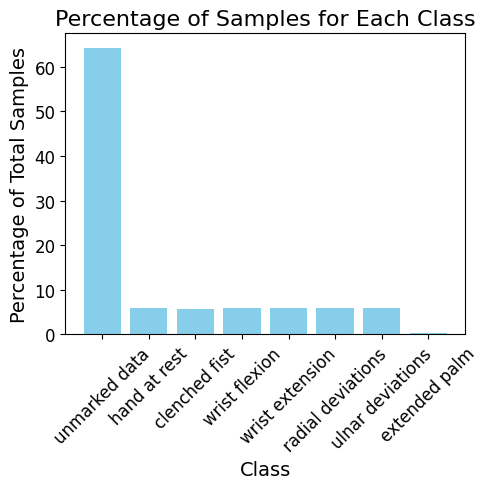

In [78]:
nonzero_count = np.count_nonzero(grouped_df.T.iloc[7])
print(f"Percentage of samples for each class relative to the total number of samples:\n")
for i in range(8):
    nonzero_count = np.count_nonzero(grouped_df.T.iloc[i])
    print(f"Percentage of samples for class {i} relative to the total number of samples: {np.sum(grouped_df.T.iloc[i])/num_samples*100:.2f}%")

print(f"\n\nNumber of nonzero elements for class {i}: {nonzero_count}, for patients {np.nonzero(grouped_df.T.iloc[7])}")

# Calculate the percentages
percentages = [np.sum(grouped_df.T.iloc[i]) / num_samples * 100 for i in range(8)]
# Plot the percentages

plt.figure(figsize=(5, 5))  # Smaller figure size
plt.bar(classes[:8], percentages, color='skyblue')
plt.xlabel('Class', fontsize=14)  # Larger x-label
plt.ylabel('Percentage of Total Samples', fontsize=14)  # Larger y-label
plt.title('Percentage of Samples for Each Class', fontsize=16)  # Larger title
plt.xticks(rotation=45, fontsize=12)  # Larger x-tick labels
plt.yticks(fontsize=12)  # Larger y-tick labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


`
Due to the limited information available on class 7 it was decided that we would only classify on the first 6 classes
`

1499054
Percentage of samples for class 0 relative to the total number of samples: 16.68%
Percentage of samples for class 1 relative to the total number of samples: 16.22%
Percentage of samples for class 2 relative to the total number of samples: 16.64%
Percentage of samples for class 3 relative to the total number of samples: 16.78%
Percentage of samples for class 4 relative to the total number of samples: 16.79%
Percentage of samples for class 5 relative to the total number of samples: 16.88%


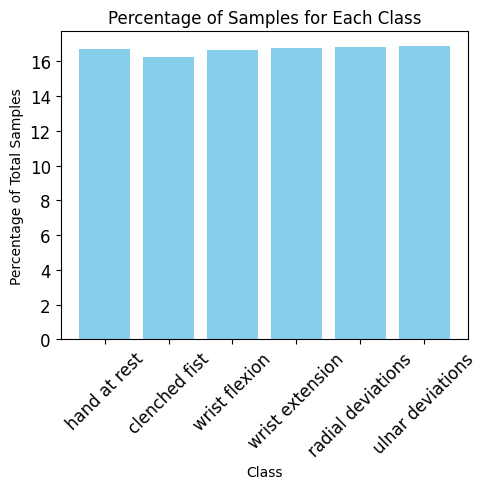

In [79]:

df_preprocessed = df[df['class'] != 7]
df_preprocessed = df_preprocessed[df_preprocessed['class'] != 0]
num_samples_processed = df_preprocessed.shape[0]
print(num_samples_processed)
grouped_df_preprocess = df_preprocessed.groupby([ 'class']).size()
classes_preprocessed = classes[1:7]
for i in range(6):
    # nonzero_count = np.count_nonzero(grouped_df_preprocess.T.iloc[i])
  
    print(f"Percentage of samples for class {i} relative to the total number of samples: {(grouped_df_preprocess.T.iloc[i])/num_samples_processed*100:.2f}%")

#  Calculate the percentages
percentages = [np.sum(grouped_df_preprocess.T.iloc[i]) / num_samples_processed * 100 for i in range(0,6)]
# Plot the percentages
plt.figure(figsize=(5, 5))
plt.bar(classes_preprocessed, percentages, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Percentage of Total Samples')
plt.title('Percentage of Samples for Each Class')
plt.xticks(rotation=45, fontsize=12)  # Larger x-tick labels
plt.yticks(fontsize=12)  # Larger y-tick labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()




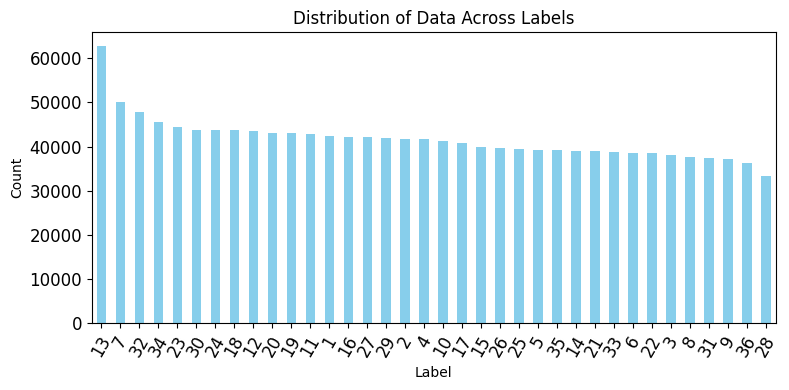

In [74]:
# Count the occurrences of each label
label_counts = df_preprocessed['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 4))
label_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Data Across Labels')
plt.xticks(rotation=60, fontsize=12)  # Larger x-tick labels
plt.yticks(fontsize=12)  # Larger y-tick labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


``
Lets us visualise the data
``

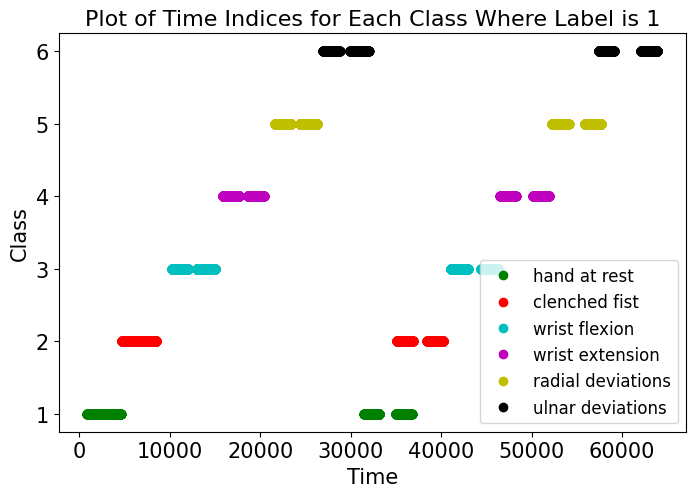

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,label
64012,880,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
64013,881,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
64014,882,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
64015,883,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
64016,884,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
...,...,...,...,...,...,...,...,...,...,...,...
4397,4576,-0.00002,0.00002,0.00000,0.00000,0.00000,0.00001,0.00001,0.00000,1,1
4398,4577,-0.00002,0.00002,0.00000,0.00000,0.00000,0.00001,0.00001,0.00000,1,1
4399,4578,-0.00002,0.00002,0.00000,0.00000,0.00000,0.00001,0.00001,0.00000,1,1
4400,4579,-0.00002,0.00002,0.00000,0.00000,0.00000,0.00001,0.00001,0.00000,1,1


In [89]:
# Define the colors for each class
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Create a figure
plt.figure(figsize=(7, 5))

# Iterate through each class and plot the markers
for class_value in range(1,7,1):  # Classes are labeled from 0 to 7
    subset = df_preprocessed[(df_preprocessed['label'] == 1) & (df_preprocessed['class'] == class_value) ]#& (df_preprocessed['time'] > 33000)
    plt.plot(subset['time'], subset['class'], 'o', label=f'Class {class_value}', color=colors[class_value])

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Class')
plt.title('Plot of Time Indices for Each Class Where Label is 1')
plt.legend(classes_preprocessed)
plt.xticks( fontsize=15)  # Larger x-tick labels
plt.yticks(fontsize=15)  # Larger y-tick labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.legend(classes_preprocessed, fontsize=12, loc='lower right')  # Adjust legend font size and position
plt.xlabel('Time', fontsize=15)  # Adjust x-label font size
plt.ylabel('Class', fontsize=15)  # Adjust y-label font size
plt.title('Plot of Time Indices for Each Class Where Label is 1', fontsize=16)  # Adjust title font size
plt.show()



subset = df_preprocessed[(df_preprocessed['label'] == 1) & (df_preprocessed['class'] == 1) & (df_preprocessed['time'] < 10000)]
subset = subset.sort_values(by='time')
subset

# Feature extraction/selection

### Window each gesture 
#### separate gestures if there is a gap in time

In [19]:
#loop through 36 labels (subjects)
#separate dataframe parts based on the 6 classes, 
# separate gesture data if there is a time gap between data (empty space)
# save the data in a dictionary with the label and class as the key

# Initialize an empty dictionary to store the separated data
data_dict = {}

# Define the time gap threshold (adjust as needed)
time_gap_threshold = 15000  # Example threshold

# Loop through each label (subject)
for label in range(1,37):
    # Loop through each class
    for class_value in range(1,7,1):
        # Filter the DataFrame for the current label and class
        subset = df_preprocessed[(df_preprocessed['label'] == label) & (df_preprocessed['class'] == class_value)]
        
        # Sort by time to ensure proper segmentation
        subset = subset.sort_values(by='time')
        
        # Identify segments of data where there is a time gap
        segments = []
        current_segment = []
        previous_time = None
        
        for _, row in subset.iterrows():
            current_time = row['time']
            if previous_time is not None and (current_time - previous_time) > time_gap_threshold:
                # Save the current segment and start a new one
                if current_segment:
                    segments.append(pd.DataFrame(current_segment))
                current_segment = []
            current_segment.append(row)
            previous_time = current_time
        
        # Add the last segment if it exists
        if current_segment:
            segments.append(pd.DataFrame(current_segment))
        # if len(segments)!=2:
        #     print(label, class_value,"  segment length is:",len(segments))
        # Save the segments in the dictionary with the label and class as the key
        # Drop the 'time' column from each segment
        # segments = [segment.drop(columns=['time']) for segment in segments]
        
        # Save the segments in the dictionary with the label and class as the key
        data_dict[(label, class_value)] = segments

# data_dict now contains the separated data for each label and class

In [20]:

# Initialize an empty list to store the new data with features
new_data = []

# Define the window size and step size (50% overlap)
window_size = 250
step_size = int(window_size*0.5)

# Function to calculate waveform length
def waveform_length(window):
    return np.sum(np.abs(np.diff(window, axis=0)), axis=0)


def zero_crossing_rate(window):
    return np.sum(np.diff(np.sign(window), axis=0) != 0, axis=0)

def peak_frequency(window):
    freq_domain = np.fft.fft(window, axis=0)
    freqs = np.fft.fftfreq(window.shape[0])
    peak_freqs = freqs[np.argmax(np.abs(freq_domain), axis=0)]
    return peak_freqs

# Loop through each label (subject)
for label in range(1, 37):
    # Loop through each class
    for class_value in range(1, 7):
        for i, segment in enumerate(data_dict[(label, class_value)]):
            # Loop through the segment with the defined window and step size
            for start in range(0, len(segment) - window_size + 1, step_size):
                window = segment.iloc[start:start + window_size]
                # Calculate features for each channel
                min_values = window.min()
                max_values = window.max()
                mean_abs_values = window.abs().mean()
                wave_lengths = waveform_length(window)
                variance_values = window.var()
               
                zero_crossings = zero_crossing_rate(window)
                std_values = window.std()
                skew_values = window.skew()
                kurt_values = window.kurtosis()
                peak_freqs = peak_frequency(window)
                mean_freq_values = np.mean(np.abs(np.fft.fft(window, axis=0)), axis=0)

                # Create a dictionary to store the features for each channel
                features = {}
                for channel in range(1, 9):
                    features[f'ch{channel}_std_value'] = std_values[channel]
                    features[f'ch{channel}_skew_value'] = skew_values[channel]
                    features[f'ch{channel}_kurt_value'] = kurt_values[channel]
                    features[f'ch{channel}_variance'] = variance_values[channel]

                    features[f'ch{channel}_min_value'] = min_values[channel]
                    features[f'ch{channel}_max_value'] = max_values[channel]
                    features[f'ch{channel}_mean_abs_value'] = mean_abs_values[channel]
                    features[f'ch{channel}_wave_length'] = wave_lengths[channel]
                    features[f'ch{channel}_zero_crossing'] = zero_crossings[channel]
                    
                    
                    features[f'ch{channel}_peak_freq'] = peak_freqs[channel]
                    features[f'ch{channel}_mean_freq_value'] = mean_freq_values[channel]
                    
      
                
                # Add class and label to the features
                features['class'] = class_value
                features['label'] = label
                features['segment'] = i
                # features['gesture_time'] = start
                
                # Append the features dictionary to the list
                new_data.append(features)

# Convert the list of dictionaries to a DataFrame
X = pd.DataFrame(new_data)

# final_df now contains the new data with features and the associated class and label

/tmp/ipykernel_1099339/2899536045.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features[f'ch{channel}_std_value'] = std_values[channel]
/tmp/ipykernel_1099339/2899536045.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features[f'ch{channel}_skew_value'] = skew_values[channel]
/tmp/ipykernel_1099339/2899536045.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features[f'ch{channel}_kurt_value'] = kurt_values[channel]


In [21]:
X.shape

(11348, 91)

In [25]:
# Define the feature names (12 feature groups, each with 8 channels)
feature_names = [
    '_min_value',
    '_max_value',
    '_mean_abs_value',
    '_wave_length',
    '_zero_crossing',
    '_skew_value', 
    '_kurt_value', 
    '_var_value', 
    '_std_value',
    '_peak_freq', 
    '_mean_freq_value'
]



# Create feature_group2 by removing one feature at a time
feature_group1 = []
for feature in feature_names:
    group = [f for f in feature_names if f != feature] + ['label']
    feature_group1.append(group)

# Define a new feature group by removing specific features
feature_group2= [[
    '_min_value',
    '_max_value',
    '_mean_abs_value',
    '_skew_value',
    '_variance',
    '_std_value',
    '_mean_freq_value', 'label'
]]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
X_standardized = scaler.fit_transform(X.drop(columns=['class', 'label','segment']))

# Define the target variable
y = X['class']

# # Split the data into training and testing sets
y_train = y[X['label'] < 30]
y_test = y[X['label'] >= 30]
X_train = X_standardized[X['label'] < 30]
X_test = X_standardized[X['label'] >= 30]

# Initialize a list to store the results
results = []

# Train and evaluate the SVM model with all features (baseline)
svm_model = SVC(kernel='rbf', tol=1e-4, C=1)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
results.append({
    'included_feature': 'All',
    'feature_group': 'All',
    'accuracy': accuracy,
    'classification_report': report
})

# Loop through each feature group and evaluate the SVM model
for group_name, feature_group in zip(['Group 1', 'Group 2'], [feature_group1, feature_group2]):
    for i, features_i in enumerate(feature_group):
        print(f"Evaluating feature group {i+1} in {group_name}")
        
        # Select the features including the current group
        X_subset = X[[col for col in X.columns if any(included_features in col for included_features in features_i)]]
        X_train_subset = X_subset[X_subset['label'] < 30]
        X_test_subset = X_subset[X_subset['label'] >= 30]
        X_train_subset = X_train_subset.drop(columns=['label'])
        X_test_subset = X_test_subset.drop(columns=['label'])
        
        # Standardize the subset of features
        X_train_subset = scaler.fit_transform(X_train_subset)
        X_test_subset = scaler.transform(X_test_subset)

        # Train and evaluate the SVM model
        svm_model = SVC(kernel='rbf', tol=1e-4, C=1)
        svm_model.fit(X_train_subset, y_train)
        y_pred = svm_model.predict(X_test_subset)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        # Store the results
        results.append({
            'included_feature': features_i,
            'feature_group': group_name,
            'accuracy': accuracy,
            'classification_report': report
        })

# Convert the results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)


Evaluating feature group 1 in Group 1
Evaluating feature group 2 in Group 1
Evaluating feature group 3 in Group 1
Evaluating feature group 4 in Group 1
Evaluating feature group 5 in Group 1
Evaluating feature group 6 in Group 1
Evaluating feature group 7 in Group 1
Evaluating feature group 8 in Group 1
Evaluating feature group 9 in Group 1
Evaluating feature group 10 in Group 1
Evaluating feature group 11 in Group 1
Evaluating feature group 1 in Group 2


In [27]:

# Convert the DataFrame to a list of lists for tabulate
results_list = results_df[['included_feature', 'accuracy']].values.tolist()

# Print the results using tabulate
print(tabulate(results_list, headers=['Included Feature', 'Accuracy'], tablefmt='grid'))

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
| Included Feature                                                                                                                                                         |   Accuracy |
+==========================================================================================================================================================================+============+
| All                                                                                                                                                                      |   0.82746  |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
| ['_max_value', '_mean_abs_value', '_wave_length', '_zero_crossing', 

In [56]:
# # Initialize the StandardScaler
scaler = StandardScaler()

# # Fit and transform the data
final_features=['_min_value', '_max_value', '_mean_abs_value', '_skew_value', '_variance', '_std_value', '_mean_freq_value', 'label','segment','class'] 

X_subset = X[[col for col in X.columns if any(included_features in col for included_features in final_features )]]
X_subset_segment_1 = X_subset[X_subset['segment'] == 0]
X_subset_segment_2 = X_subset[X_subset['segment'] == 1]

np.random.seed(1)  # For reproducibility
all_labels = np.unique(X['label'])
train_labels = np.random.choice(all_labels, 28, replace=False)
test_val_labels = np.setdiff1d(all_labels, train_labels)

# Assign the labels to the respective sets
y=X['class']

# Further segment the data where segment == 1

# Assign the labels to the respective sets

X_train = X_subset[X_subset['label'].isin(train_labels)]
X_test = X_subset_segment_1[X_subset_segment_1['label'].isin(test_val_labels)]
X_val = X_subset_segment_2[X_subset_segment_2['label'].isin(test_val_labels)]

y_train = X_train['class']
y_test = X_test['class']
y_val = X_val['class']

# Standardize the subset of features
X_train = scaler.fit_transform(X_train.drop(columns=['label','segment','class']))
X_test = scaler.fit_transform(X_test.drop(columns=['label','segment','class']))
X_val = scaler.fit_transform(X_val.drop(columns=['label','segment','class']))

print(X_train.shape)
print(X_test.shape)

# Calculate and print the percentages
train_percentage = len(X_train) / len(X_subset) * 100
test_percentage = len(X_test) / len(X_subset) * 100

print(f"Training set percentage: {train_percentage:.2f}%")
print(f"Test set percentage: {test_percentage:.2f}%")
print(f"Validation set percentage: {100-train_percentage-test_percentage:.2f}%")


(8701, 56)
(1334, 56)
Training set percentage: 76.67%
Test set percentage: 11.76%
Validation set percentage: 11.57%



# Model selection/implementation


In [101]:
# Plot the confusion matrix for the testing set
from sklearn.metrics import ConfusionMatrixDisplay
def test_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    print('===Testing results===')
    print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.3f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Recall: {:.3f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('F1 score: {:.3f}'.format(f1_score(y_test, y_pred, average='weighted')))
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report) 

def compact_confusion_matrix(model, X_test, y_test,name):
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    disp.ax_.set_xlabel('Predicted Label', fontsize=16)
    disp.ax_.set_ylabel('True Label', fontsize=16)
    disp.ax_.tick_params(axis='both', labelsize=14)  # Increase tick label size
    for text in disp.ax_.texts:  # Increase font size of the matrix values
        text.set_fontsize(14)

    # Save the figure with a tight layout and larger DPI for better quality
    plt.savefig(name, bbox_inches='tight', dpi=300) 
    plt.show()


## Grid search for hyperparameter tuning


In [58]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

array([[-9.13878954e-01, -1.32836466e+00, -5.07480040e-01, ...,
        -9.68139537e-01, -8.82171913e-01, -9.18389456e-01],
       [-8.85497715e-01, -2.69450449e-01, -5.06415295e-01, ...,
        -9.68139537e-01, -8.91549815e-01, -9.16826095e-01],
       [-8.54990029e-01, -7.10705443e-02, -5.04800894e-01, ...,
        -9.68139537e-01, -9.04946819e-01, -9.23637352e-01],
       ...,
       [-5.10423172e-01,  2.64754345e-03, -4.52765678e-01, ...,
        -5.42770361e-01, -5.68012174e-01, -5.68221224e-01],
       [-5.75060333e-01,  3.41140476e-01, -4.67259283e-01, ...,
        -7.71815302e-01, -5.91456931e-01, -6.19541155e-01],
       [-2.75269785e-01,  2.78584155e+00, -3.81599181e-01, ...,
        -7.06373890e-01, -5.80404403e-01, -6.21690814e-01]])

In [59]:
# KNN parameter grid
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

print(f"=== Performing Grid Search for KNN ===")
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)
print(f"Best parameters: {grid_search_knn.best_params_}")
print(f"Validation accuracy: {grid_search_knn.score(X_val, y_val)}")  

=== Performing Grid Search for KNN ===
Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Best cross-validation accuracy: 0.799225375824437
Validation accuracy: 0.8857578065498858


In [60]:
# SVM parameter grid for different kernels
svm_param_grid = {
'linear': {
    'C': [0.01, 0.1, 1, 10, 100],
    'tol': [1e-4],
    'class_weight': [None, 'balanced']
},
'rbf': {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'auto', 'scale'],
    'tol': [1e-4],
    'class_weight': [None, 'balanced']
},
'poly': {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'auto', 'scale'],
    'degree': [2, 3, 4],
    'coef0': [0, 0.1, 0.5],  # Only used in polynomial and sigmoid kernels
    'tol': [1e-4],
    'class_weight': [None, 'balanced']
}
}

print(f"=== Performing Grid Search for SVM ===")
for kernel, param_grid in svm_param_grid.items():
    print(f"Kernel: {kernel}")
    svm = SVC(kernel=kernel)
    grid_search_svm = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
    grid_search_svm.fit(X_train, y_train)
    print(f"Best parameters: {grid_search_svm.best_params_}")
    print(f"Validation accuracy: {grid_search_svm.score(X_val, y_val)}")  

=== Performing Grid Search for SVM ===
Kernel: linear
Best parameters: {'C': 0.01, 'class_weight': None, 'tol': 0.0001}
Test accuracy: 0.9017517136329017
Kernel: rbf
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.01, 'tol': 0.0001}
Test accuracy: 0.8994668697638994
Kernel: poly
Best parameters: {'C': 0.01, 'class_weight': 'balanced', 'coef0': 0.5, 'degree': 2, 'gamma': 0.1, 'tol': 0.0001}
Test accuracy: 0.8964204112718964


In [90]:
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (100, 50), (150, 100, 50)],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'batch_size': [32, 64, 128],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

# Use RandomizedSearchCV to explore a random subset of the parameter grid
print(f"=== Performing Grid Search for MLP ===")
mlp = MLPClassifier(max_iter=300, random_state=42)
random_search_mlp = RandomizedSearchCV(mlp, mlp_param_grid, n_iter=30, cv=5, scoring='accuracy', random_state=42)
random_search_mlp.fit(X_train, y_train)

print(f"Best parameters: {random_search_mlp.best_params_}")
print(f"Test accuracy: {random_search_mlp.score(X_test, y_test)}")   

=== Performing Grid Search for MLP ===
Best parameters: {'solver': 'sgd', 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 100), 'batch_size': 32, 'alpha': 0.1, 'activation': 'relu'}
Test accuracy: 0.8935532233883059



## KNN


Model with 9 neighbors saved as models/knn_9_neighbors_12.pkl

===Testing results===
Accuracy: 0.861
Precision: 0.864
Recall: 0.861
F1 score: 0.861
Classification Report:
              precision    recall  f1-score   support

           1       0.96      1.00      0.98       232
           2       0.92      0.83      0.87       200
           3       0.72      0.74      0.73       218
           4       0.85      0.95      0.90       223
           5       0.94      0.84      0.89       228
           6       0.80      0.79      0.79       233

    accuracy                           0.86      1334
   macro avg       0.86      0.86      0.86      1334
weighted avg       0.86      0.86      0.86      1334

Validation results
===Testing results===
Accuracy: 0.886
Precision: 0.887
Recall: 0.886
F1 score: 0.885
Classification Report:
              precision    recall  f1-score   support

           1       0.96      1.00      0.98       203
           2       0.92      0.90      0.91       

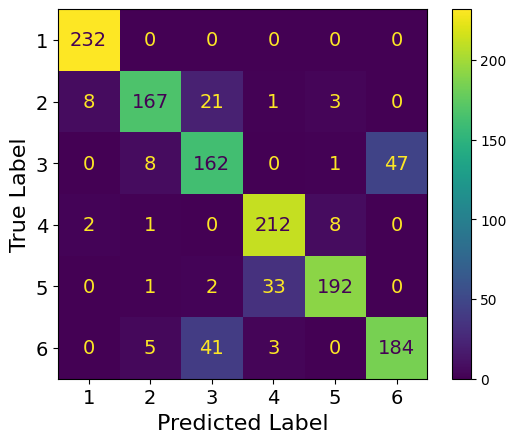

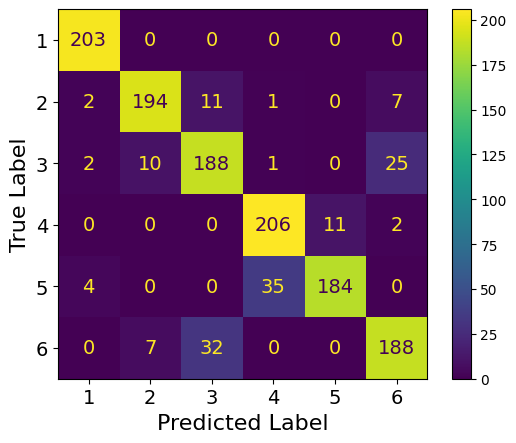

In [120]:
# Define the directory and base filename
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

n_neighbors = 9 # Best parameter from Grid SearchBest 
# Initialize the KNN model with the specified number of neighbors
knn_model = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=n_neighbors, p=1, weights='uniform')

# Fit the model
knn_model.fit(X_train, y_train)

#Prepare the model filename with n_neighbors
version = 1
while True:
    model_filename = f"knn_{n_neighbors}_neighbors_{version}.pkl"
    model_path = os.path.join(model_dir, model_filename)
    if not os.path.exists(model_path):
        break
    version += 1
    
# Save the model
with open(model_path, 'wb') as f:
    pickle.dump({'model': knn_model}, f)
print(f"Model with {n_neighbors} neighbors saved as {model_path}\n")

# Test the model
test_model(knn_model,X_test,y_test)
print("Validation results")
test_model(knn_model,X_val,y_val)


compact_confusion_matrix(knn_model, X_test, y_test, "task2_cm_knn.png")


compact_confusion_matrix(knn_model, X_val, y_val, "task2_cm_knn_val.png")



## SVM


Model with linear kernel saved as models/linear_svm_14.pkl

kernel: linear
C: 0.01
class_weight: None
tol: 0.0001


===Testing results===
Accuracy: 0.898
Precision: 0.906
Recall: 0.898
F1 score: 0.898
Classification Report:
              precision    recall  f1-score   support

           1       0.96      1.00      0.98       232
           2       0.94      0.86      0.90       200
           3       0.75      0.92      0.83       218
           4       0.88      0.96      0.92       223
           5       0.97      0.88      0.92       228
           6       0.93      0.77      0.84       233

    accuracy                           0.90      1334
   macro avg       0.90      0.90      0.90      1334
weighted avg       0.91      0.90      0.90      1334



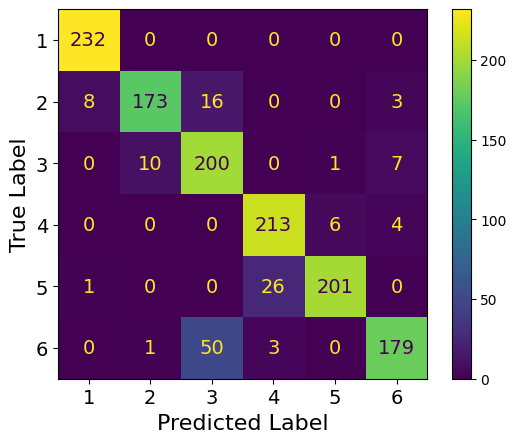

Validation results
===Testing results===
Accuracy: 0.902
Precision: 0.903
Recall: 0.902
F1 score: 0.902
Classification Report:
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       203
           2       0.92      0.93      0.92       215
           3       0.80      0.86      0.83       226
           4       0.90      0.94      0.92       219
           5       0.96      0.88      0.92       223
           6       0.87      0.82      0.85       227

    accuracy                           0.90      1313
   macro avg       0.90      0.90      0.90      1313
weighted avg       0.90      0.90      0.90      1313



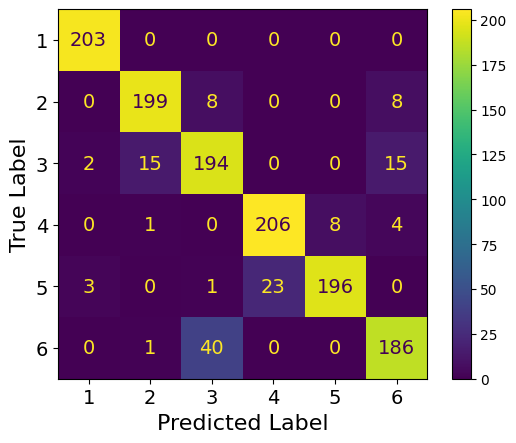

Model with rbf kernel saved as models/rbf_svm_12.pkl

kernel: rbf
gamma: 0.01
C: 0.1
class_weight: balanced
tol: 0.0001


===Testing results===
Accuracy: 0.894
Precision: 0.902
Recall: 0.894
F1 score: 0.895
Classification Report:
              precision    recall  f1-score   support

           1       0.96      1.00      0.98       232
           2       0.98      0.85      0.91       200
           3       0.73      0.90      0.81       218
           4       0.91      0.93      0.92       223
           5       0.93      0.93      0.93       228
           6       0.90      0.75      0.82       233

    accuracy                           0.89      1334
   macro avg       0.90      0.89      0.89      1334
weighted avg       0.90      0.89      0.89      1334



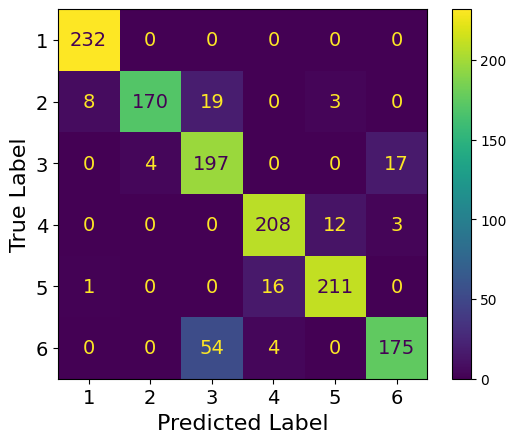

Validation results
===Testing results===
Accuracy: 0.899
Precision: 0.903
Recall: 0.899
F1 score: 0.900
Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.98       203
           2       0.99      0.93      0.95       215
           3       0.78      0.90      0.84       226
           4       0.89      0.92      0.91       219
           5       0.91      0.86      0.88       223
           6       0.89      0.81      0.85       227

    accuracy                           0.90      1313
   macro avg       0.90      0.90      0.90      1313
weighted avg       0.90      0.90      0.90      1313



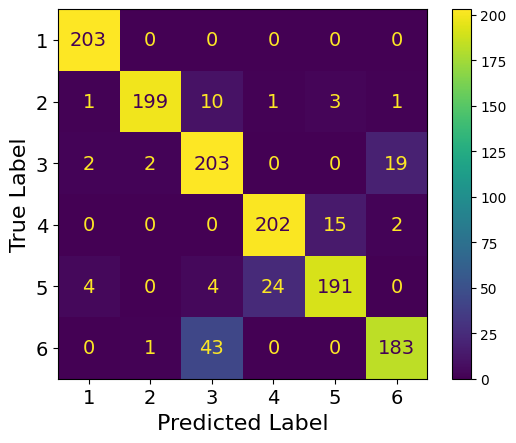

Model with poly kernel saved as models/poly_svm_11.pkl

kernel: poly
degree: 2
gamma: 0.1
C: 0.01
coef0: 0.5
class_weight: balanced
tol: 0.0001


===Testing results===
Accuracy: 0.897
Precision: 0.903
Recall: 0.897
F1 score: 0.897
Classification Report:
              precision    recall  f1-score   support

           1       0.95      1.00      0.97       232
           2       0.96      0.84      0.90       200
           3       0.74      0.90      0.81       218
           4       0.94      0.90      0.92       223
           5       0.91      0.95      0.93       228
           6       0.92      0.79      0.85       233

    accuracy                           0.90      1334
   macro avg       0.90      0.90      0.90      1334
weighted avg       0.90      0.90      0.90      1334



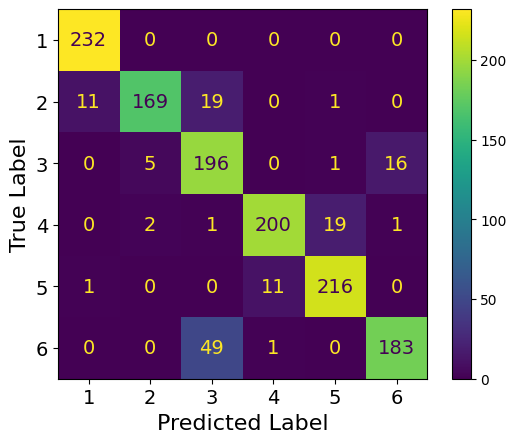

Validation results
===Testing results===
Accuracy: 0.896
Precision: 0.900
Recall: 0.896
F1 score: 0.897
Classification Report:
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       203
           2       0.95      0.89      0.92       215
           3       0.77      0.88      0.82       226
           4       0.90      0.91      0.91       219
           5       0.92      0.89      0.91       223
           6       0.88      0.82      0.85       227

    accuracy                           0.90      1313
   macro avg       0.90      0.90      0.90      1313
weighted avg       0.90      0.90      0.90      1313



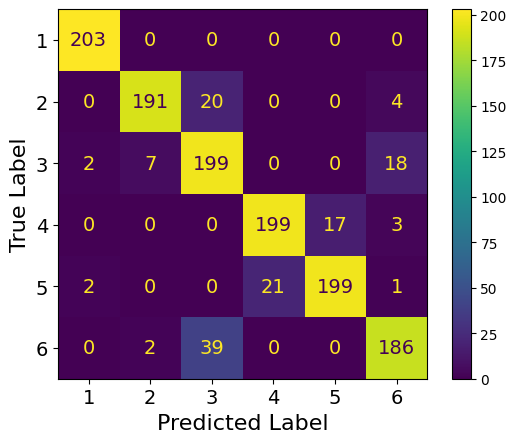

In [121]:
# Define the different kernels with their corresponding hyperparameters
svm_param_grid = [
    {'kernel': 'linear', 'C': 0.01, 'class_weight': None, 'tol': 1e-4}, 
    {'kernel': 'rbf', 'gamma': 0.01, 'C': 0.1, 'class_weight': 'balanced', 'tol': 1e-4}, 
    {'kernel': 'poly', 'degree': 2, 'gamma': 0.1, 'C': 0.01, 'coef0': 0.5, 'class_weight': 'balanced', 'tol': 1e-4}
]


# Iterate over each parameter grid
for param_grid in svm_param_grid:
    # Initialize the SVM model with the kernel and its parameters from the param_grid
    svm_model = SVC(**param_grid)
    
    # Fit the model
    svm_model.fit(X_train, y_train)
    
    # Prepare the model filename with kernel name
    kernel = param_grid['kernel']
    version = 1
    while True:
        model_filename = f"{kernel}_svm_{version}.pkl"
        model_path = os.path.join(model_dir, model_filename)
        if not os.path.exists(model_path):
            break
        version += 1

    # Save the model
    with open(model_path, 'wb') as f:
        pickle.dump({'model': svm_model}, f)

    print(f"Model with {kernel} kernel saved as {model_path}\n")

     # Print the kernel name and hyperparameters
    for key, value in param_grid.items():
        print(f"{key}: {value}")
    print("\n")

  
    test_model(svm_model,X_test,y_test)
    compact_confusion_matrix(svm_model, X_test, y_test, f"task2_cm_svm_{kernel}.png")
    print("Validation results")
    test_model(svm_model,X_val,y_val)
    compact_confusion_matrix(svm_model, X_val, y_val, f"task2_cm_svm_{kernel}_val.png")




## MLP


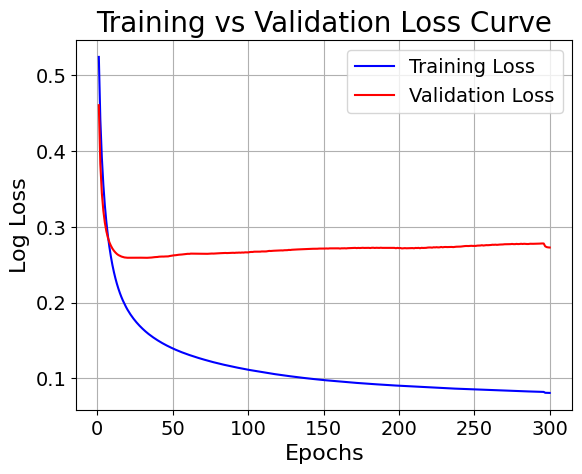

===Testing results===
Accuracy: 0.892
Precision: 0.897
Recall: 0.892
F1 score: 0.893
Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.99       232
           2       0.94      0.84      0.89       200
           3       0.72      0.85      0.78       218
           4       0.91      0.96      0.93       223
           5       0.95      0.91      0.93       228
           6       0.88      0.79      0.83       233

    accuracy                           0.89      1334
   macro avg       0.90      0.89      0.89      1334
weighted avg       0.90      0.89      0.89      1334



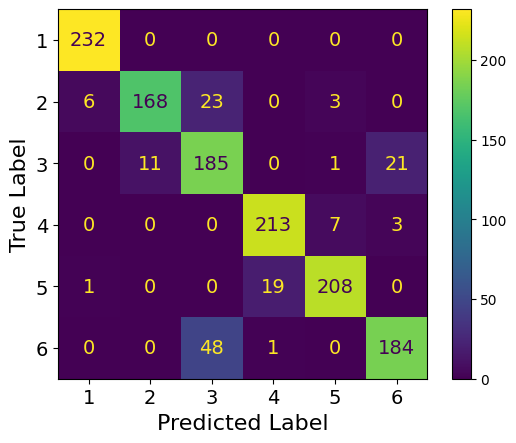

Validation results
===Testing results===
Accuracy: 0.909
Precision: 0.910
Recall: 0.909
F1 score: 0.909
Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.98       203
           2       0.93      0.86      0.89       215
           3       0.82      0.87      0.84       226
           4       0.91      0.96      0.94       219
           5       0.98      0.91      0.94       223
           6       0.87      0.87      0.87       227

    accuracy                           0.91      1313
   macro avg       0.91      0.91      0.91      1313
weighted avg       0.91      0.91      0.91      1313



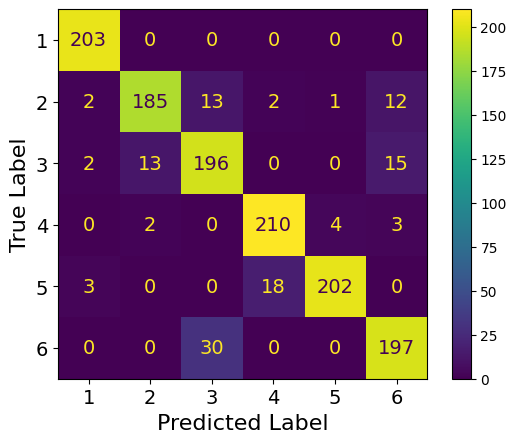

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss

# Simulate some data
# X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Randomly split X_test into 2 sets equally
np.random.seed(42)  # For reproducibility
indices = np.random.permutation(len(X_test))
half = len(X_test) // 2

# Initialize MLPClassifier parameters
mlp_model = MLPClassifier(
    solver='sgd', 
    learning_rate_init=0.001, 
    learning_rate='adaptive', 
    hidden_layer_sizes=(100, 100), 
    batch_size=32, 
    alpha=0.1, 
    activation='relu', 
    max_iter=300, 
    random_state=42,
    verbose=False
)

# Store losses for plotting
train_losses = []
val_losses = []

# First call to partial_fit needs classes
mlp_model.partial_fit(X_train, y_train, classes=np.unique(y))

# Train the model and record losses
for i in range(1, mlp_model.max_iter + 1):
    mlp_model.partial_fit(X_train, y_train)  # Fit the model incrementally
    y_train_pred = mlp_model.predict_proba(X_train)
    y_val_pred = mlp_model.predict_proba(X_val)

    # Calculate log loss for training and validation sets
    train_loss = log_loss(y_train, y_train_pred)
    val_loss = log_loss(y_val, y_val_pred)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plotting the losses
# plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.title('Training vs Validation Loss Curve', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Log Loss', fontsize=16)
plt.legend(fontsize=14)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("task2_loss_curve.png", bbox_inches='tight', dpi=300)
plt.show()


test_model(mlp_model,X_test,y_test)
compact_confusion_matrix(mlp_model, X_test, y_test, "task2_cm_mlp.png")

print("Validation results")
test_model(mlp_model,X_val,y_val)


compact_confusion_matrix(mlp_model, X_val, y_val, "task2_cm_mlp_val.png")


In [35]:
#old search results
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (100, 50), (150, 100, 50)],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'batch_size': [32, 64, 128],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

# Use RandomizedSearchCV to explore a random subset of the parameter grid
mlp = MLPClassifier(max_iter=300, random_state=42)
random_search_mlp = RandomizedSearchCV(mlp, mlp_param_grid, n_iter=30, cv=5, scoring='accuracy', random_state=42)
random_search_mlp.fit(X_train, y_train)

print(f"Best parameters: {random_search_mlp.best_params_}")
print(f"Test accuracy: {random_search_mlp.score(X_test, y_test)}")

Best parameters: {'solver': 'sgd', 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 100), 'batch_size': 32, 'alpha': 0.1, 'activation': 'relu'}
Test accuracy: 0.8624220837043634


# Ensemble models


Best parameters: {'criterion': 'entropy', 'max_depth': 40, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
Best cross-validation score: 0.7515322149379072
===Testing results===
Accuracy: 0.795
Precision: 0.800
Recall: 0.795
F1 score: 0.793
Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.99       232
           2       0.72      0.84      0.77       200
           3       0.68      0.73      0.70       218
           4       0.76      0.84      0.80       223
           5       0.85      0.72      0.78       228
           6       0.81      0.64      0.71       233

    accuracy                           0.79      1334
   macro avg       0.80      0.80      0.79      1334
weighted avg       0.80      0.79      0.79      1334



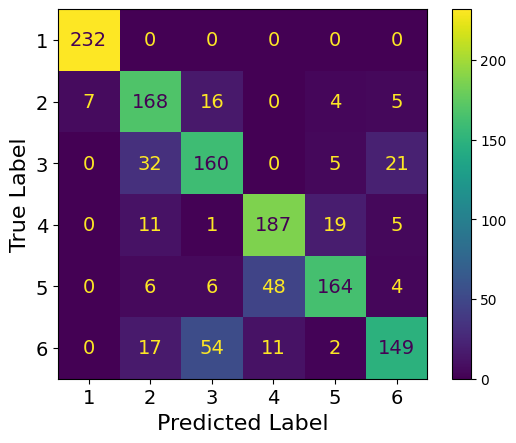

Validation results
===Testing results===
Accuracy: 0.812
Precision: 0.816
Recall: 0.812
F1 score: 0.810
Classification Report:
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       203
           2       0.74      0.86      0.79       215
           3       0.74      0.79      0.76       226
           4       0.79      0.87      0.83       219
           5       0.82      0.74      0.78       223
           6       0.83      0.64      0.73       227

    accuracy                           0.81      1313
   macro avg       0.82      0.82      0.81      1313
weighted avg       0.82      0.81      0.81      1313



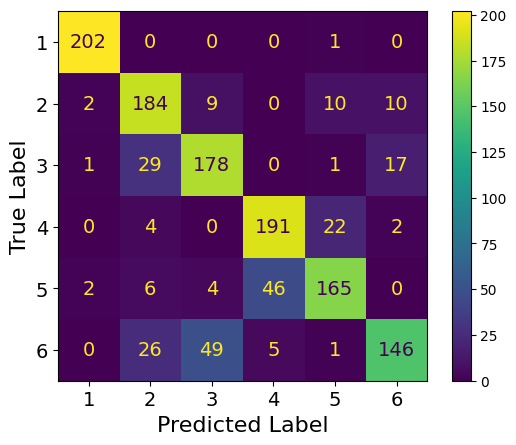

In [123]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid for the Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier()

# Initialize the GridSearchCV with the Decision Tree and the parameter grid
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# Test the best model on the test set
tree_model = grid_search.best_estimator_

test_model(tree_model,X_test,y_test)
compact_confusion_matrix(tree_model, X_test, y_test, "task2_cm_tree.png")

print("Validation results")
test_model(tree_model,X_val,y_val)


compact_confusion_matrix(tree_model, X_val, y_val, "task2_cm_tree_val.png")



1
2
3
4
5
10
20
40
60
100
120
===Testing results===
Accuracy: 0.893
Precision: 0.901
Recall: 0.893
F1 score: 0.892
Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.98       232
           2       0.87      0.94      0.90       200
           3       0.78      0.90      0.84       218
           4       0.85      0.94      0.89       223
           5       0.95      0.85      0.90       228
           6       0.98      0.74      0.84       233

    accuracy                           0.89      1334
   macro avg       0.90      0.89      0.89      1334
weighted avg       0.90      0.89      0.89      1334



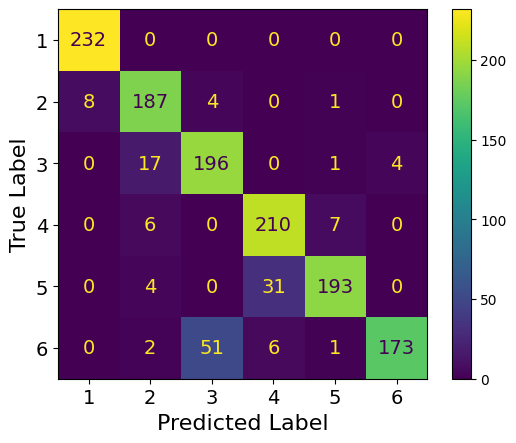

Validation results
===Testing results===
Accuracy: 0.902
Precision: 0.909
Recall: 0.902
F1 score: 0.901
Classification Report:
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       203
           2       0.92      0.93      0.93       215
           3       0.76      0.93      0.84       226
           4       0.90      0.95      0.92       219
           5       0.95      0.89      0.92       223
           6       0.94      0.72      0.81       227

    accuracy                           0.90      1313
   macro avg       0.91      0.90      0.90      1313
weighted avg       0.91      0.90      0.90      1313



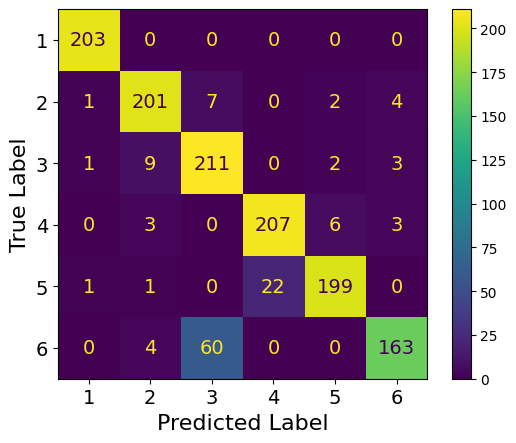

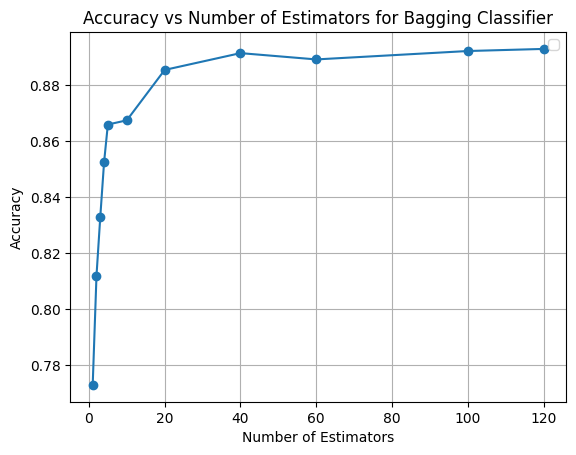

In [124]:

from sklearn.model_selection import GridSearchCV



# Initialize an empty list to store the accuracy for each number of estimators
accuracies_bag = []

n_estimators_range=[1,2,3,4,5,10,20,40,60,100,120]
# Iterate over each number of estimators
# Set the base learner as a decision tree with the specified parameters
base_learner = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    max_features=None,
    min_samples_leaf=4,
    min_samples_split=2,
    splitter='best'
)


    # Iterate over each number of estimators
for n_estimators in n_estimators_range:
    print(n_estimators)
    # Initialize the BaggingClassifier with the base estimator and current number of estimators
    bagging_model = BaggingClassifier(estimator=base_learner, n_estimators=n_estimators, random_state=42,)
    
    # Train the BaggingClassifier on the training data
    bagging_model.fit(X_train, y_train)
    
    # Test the model
    y_pred = bagging_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies_bag.append({'n_estimators': n_estimators,'accuracy': accuracy})
    
# Convert the list of dictionaries to a DataFrame
accuracies_df = pd.DataFrame(accuracies_bag)

# Test the model
test_model(bagging_model,  X_test, y_test)


# Plot the confusion matrix for the testing set
compact_confusion_matrix(bagging_model, X_test, y_test, "task2_cm_bagging.png")
print("Validation results")
test_model(bagging_model,  X_val, y_val)
compact_confusion_matrix(bagging_model, X_val, y_val, "task2_cm_bagging_val.png")


# Plot the accuracy vs n_estimators
# plt.figure(figsize=(10, 6))


plt.plot(accuracies_df['n_estimators'], accuracies_df['accuracy'], marker='o', linestyle='-')

plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Estimators for Bagging Classifier')
plt.grid(True)
plt.legend()
plt.savefig('accuracy_vs_n_estimators.jpg')
plt.show()
